### Ship sailing strategies -- get upperbound for Power to v function

In [1]:
import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# OpenTNSim
import opentnsim
import opentnsim.strategy
# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')



### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

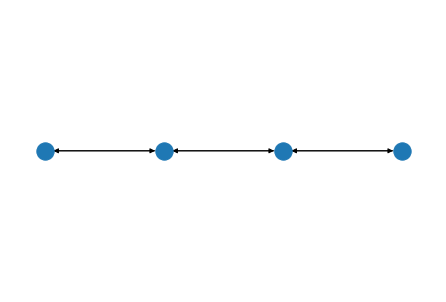

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1


for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]
for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 2.5

# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 2.5
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 2.5
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
        
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 1,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":False,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }          


### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)
path_bottleneck = nx.dijkstra_path(FG, node_2.name, node_3.name)

In [34]:
def get_upperbound_for_power2v():
    ''' for each edge with a water depth, it computes a maximum installed power allowed velocity, considering squat. this velocity is set as upperbound in the power2v function in energy.py 
    "upperbound" is the maximum value in velocity searching range.'''
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    
    # vessel.route = path_bottleneck
    # todo: it is risky to use variables that are defined outside this function (globals)
    vessel.route = path_bottleneck
    v = vessel.v
    
    depths = []
    for e in zip(vessel.route[:-1], vessel.route[1:]):
        edge = env.FG.edges[e]
        depth = edge['Info']['GeneralDepth']
        depths.append(depth)
    for depth in depths:
        h_0 = depth
    print(h_0)
    def get_grounding_v(vessel, h_0, bounds=(0, 10)):
        
        def seek_v_given_z(v, vessel, h_0):
            h_0 = depth
            z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (150 * h_0)) ** 0.81) * ((v*1.94) ** 2.08) / 20
            z_given = h_0 - vessel._T
            # compute difference between a given draught (T_strategy) and a computed draught (T_computed)

            diff = z_given - z_computed

            return diff ** 2
        
        fun = functools.partial(seek_v_given_z, vessel=vessel, h_0 = h_0)
        fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')
        # check if we found a minimum
        if not fit.success:
            raise ValueError(fit)

        # the value of fit.x within the bound (0,10) is the velocity we find where the diff**2 reach a minimum (zero).
        grounding_v =  fit.x
        print(grounding_v)
        return grounding_v    
                  
    # prepare the task to be done
    # create a large velocity[m/s] range for both inland shipping and seagoing shipping
    grounding_v = get_grounding_v(vessel,h_0,bounds=(0, 10))
    velocity = np.linspace(0.01, grounding_v, 1000)
    task = list(itertools.product(velocity[0:-1]))

    # prepare a list of dictionaries for pandas
    rows = []
    for item in task:
        row = {"velocity": item[0]}
        rows.append(row)

    # these are all the simulations that we want to run
    # convert them to dataframe, so that we can apply a function and monitor progress
    task_df = pd.DataFrame(rows)
    
    # creat a results empty list to collect the below results
    results = []   
    for i, row in tqdm.tqdm(task_df.iterrows()):
        h_0 = depth      
        velocity = row['velocity']
        
        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (150 * h_0)) ** 0.81) * ((velocity*1.94) ** 2.08) / 20
        h_0 = h_0 - z_computed
        vessel.calculate_properties()
        vessel.calculate_frictional_resistance(v=velocity, h_0=h_0)
        vessel.calculate_total_resistance(v=velocity, h_0=h_0)
        P_tot = vessel.calculate_total_power_required(v=velocity)
        result = {}
        result.update(row)
        result['Powerallowed_v'] = velocity
        result['P_tot'] = P_tot
        result['P_installed'] = vessel.P_installed
        results.append(result)
    
    results_df = pd.DataFrame(results)
    results_df.head(100)
    selected = results_df.query('P_tot < P_installed')
    upperbound = max(selected['Powerallowed_v'])
    
    return upperbound

In [35]:
bottleneck_upperbound = get_upperbound_for_power2v( )
# print(upperbound)
bottleneck_upperbound

2.5
4.723912307860974


999it [00:00, 1927.37it/s]


3.756592965407021

In [36]:
def get_upperbound_for_power2v(vessel, width=150, depth=2.5, upperbound_search_interval=20):
    ''' for a waterway section with a given width and depth, compute a maximum installed-
    power-allowed velocity, considering squat. This velocity is set as upperbound in the 
    power2v function in energy.py "upperbound" is the maximum value in velocity searching 
    range.'''
    
    def get_grounding_v(vessel, width, depth, bounds):
        
        def seek_v_given_z(v, vessel, width, depth):
            # calculate sinkage
            z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((v*1.94) ** 2.08) / 20
            
            # calculate available underkeel clearance (vessel in rest)
            z_given = depth - vessel._T
            
            # compute difference between the sinkage and the space available for sinkage
            diff = z_given - z_computed

            return diff ** 2
        
        # goalseek to minimize
        fun = functools.partial(seek_v_given_z, vessel=vessel, width=width, depth=depth)
        fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')
        
        # check if we found a minimum
        if not fit.success:
            raise ValueError(fit)

        # the value of fit.x within the bound (0,10) is the velocity we find where the diff**2 reach a minimum (zero).
        grounding_v =  fit.x
        
        print('grounding velocity {:.2f} m/s'.format(grounding_v))
        
        return grounding_v    
                  

    # create a large velocity[m/s] range for both inland shipping and seagoing shipping
    grounding_v = get_grounding_v(vessel, width, depth, bounds=(0, upperbound_search_interval))
    velocity = np.linspace(0.01, grounding_v, upperbound_search_interval) # reduce width of the interval to save calculation time
    task = list(itertools.product(velocity[0:-1]))

    # prepare a list of dictionaries for pandas
    rows = []
    for item in task:
        row = {"velocity": item[0]}
        rows.append(row)

    # convert simulations to dataframe, so that we can apply a function and monitor progress
    task_df = pd.DataFrame(rows)
    
    # creat a results empty list to collect the below results
    results = []   
    for i, row in tqdm.tqdm(task_df.iterrows()):
        h_0 = depth      
        velocity = row['velocity']
        
        # calculate squat and the waterdepth after squat
        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (150 * h_0)) ** 0.81) * ((velocity*1.94) ** 2.08) / 20
        h_0 = depth - z_computed
        
        # for the squatted water depth calculate resistance and power
        vessel.calculate_properties()
        vessel.calculate_frictional_resistance(v=velocity, h_0=h_0)
        vessel.calculate_total_resistance(v=velocity, h_0=h_0)
        P_tot = vessel.calculate_total_power_required(v=velocity)
        
        # prepare a row
        result = {}
        result.update(row)
        result['Powerallowed_v'] = velocity
        result['P_tot'] = P_tot
        result['P_installed'] = vessel.P_installed
        
        # update resulst dict
        results.append(result)
    
    results_df = pd.DataFrame(results)

    selected = results_df.query('P_tot < P_installed')
    upperbound = max(selected['Powerallowed_v'])
    
    return upperbound

In [37]:
# get vessel 
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

bottleneck_upperbound = get_upperbound_for_power2v(vessel, width=150, depth=2.5, upperbound_search_interval=10)

print('upperbound velocity {:.2f} m/s'.format(bottleneck_upperbound))

grounding velocity 4.72 m/s


9it [00:00, 2641.25it/s]

upperbound velocity 3.68 m/s
